In [1]:
"""
Example usage of aggregated NHCI drifter data v1.

Example code for loading and working with Spotter data from the NHCI
aggregated drifter dataset in Python .pickle format. Since all datasets
have the same variable names and structure, this example framework can
also be used for DWSD and microSWIFT drifters.

This notebook is based on the really nice example provided by Jacob Davis (davisjr@uw.edu)
"""

import os
import pickle
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import pandas as pd

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP/buoy_data/'
DATA_FILENAME = 'hurricane_ian_spotter_data_v1.pickle'

with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    spotter = pickle.load(handle)

# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter_ids = list(spotter.keys())

for id in spotter_ids:
    print(id)

SPOT-30068D
SPOT-30097D
SPOT-30096D
SPOT-30104D
SPOT-30024D
SPOT-30065D


In [2]:
# The data for a single id (e.g. the first) can be accessed as:
spotter_id = spotter_ids[0] # = 'SPOT-30068D'
spotter[spotter_id].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2022-09-27 00:15:55+00:00 to 2022-09-29 23:55:55+00:00
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 216 non-null    float64
 1   longitude                216 non-null    float64
 2   significant_height       72 non-null     float64
 3   peak_period              72 non-null     float64
 4   peak_direction           72 non-null     float64
 5   peak_directional_spread  72 non-null     float64
 6   mean_period              72 non-null     float64
 7   mean_direction           72 non-null     float64
 8   mean_directional_spread  72 non-null     float64
 9   frequency                72 non-null     object 
 10  energy_density           72 non-null     object 
 11  a1                       72 non-null     object 
 12  b1                       72 non-null     object 
 13  a2                       72 non

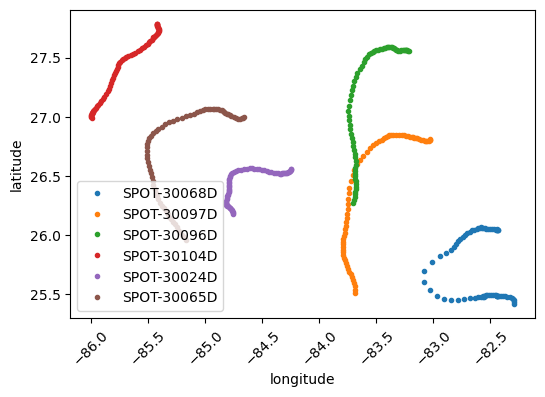

In [3]:
# example: plot lat, lon for positions with valid wave data
fig, ax = plt.subplots(figsize=(6,4))
for spotter_id in spotter.keys():
    only_waves = spotter[spotter_id]['energy_density'].notnull()
    ax.plot(
        spotter[spotter_id][only_waves]['longitude'],
        spotter[spotter_id][only_waves]['latitude'],'.',
        label = spotter_id,
    )
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.legend()
ax.tick_params(axis='x', rotation=45)

In [4]:
# Open a file text to be cut+pasted into SWAN input file
f = open('spec2d.txt', 'w')


for spotter_id in spotter.keys():
    # Some rows have times with other data but no wave info
    only_waves = spotter[spotter_id]['energy_density'].notnull()
    spotter[spotter_id][only_waves]
    ipt = 0 # index must stay below 100 or file names will be too long
    for index, row in spotter[spotter_id][only_waves].iterrows():
        #print(index, row['latitude'])
        pname = "{}{:02d}".format(spotter_id[5:], ipt)
        starttime = index.strftime('%Y%m%d.%H%m')
        pline = ("POINTS '{}' {:.4f} {:.4f}".format(pname, row['longitude'], row['latitude'] )) 
        sline = "SPECOUT '{}' SPEC2D ABS '{}.spc2d' OUTPUT {} 1000 HR".format( pname, pname, starttime )
        # print(pline)
        # print(sline)
        f.write(pline+'\n')
        f.write(sline+'\n')
        ipt +=1
        if(ipt >= 100):
            print("Warning: SWAN output filename prefix exceeds 8 chars.")
    
f.close()

Text(0.5, 1.0, 'SPOT-30065D significant wave height')

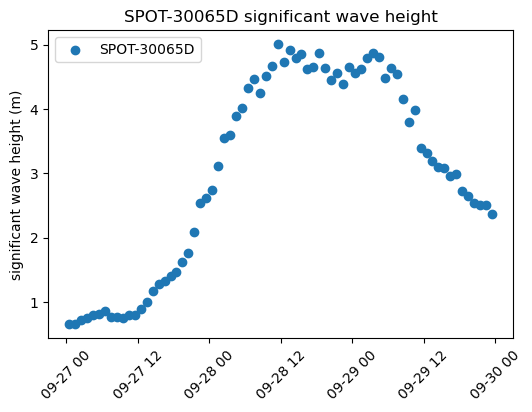

In [5]:
# Variables are queried using the column name:
spotter[spotter_id]['significant_height']

# The DataFrame is indexed by time. The array of datetimes can be
# accessed using the index property; this also enables slicing the
# dataset over two datetimes.
spotter[spotter_id].index # array of datetimes

start_date = datetime(2022,9,28, tzinfo=timezone.utc)
end_date = datetime(2022,9,29, tzinfo=timezone.utc)
spotter[spotter_id][start_date:end_date] # data from 2022-09-28 to 2022-09-29

# example: plot significant wave height over the entire dataset.
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(
    spotter[spotter_id].index,
    spotter[spotter_id]['significant_height'],
    label = spotter_id,
)
ax.set_ylabel('significant wave height (m)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.set_title(f'{spotter_id} significant wave height')

Text(0.5, 1.0, 'SPOT-30065D significant wave height from \n 2022-09-28 00:00:00+00:00 to 2022-09-29 00:00:00+00:00')

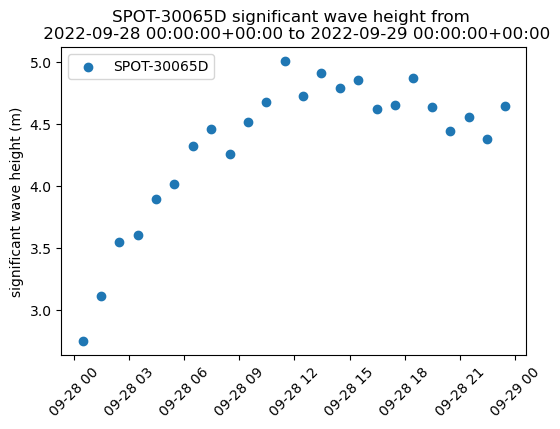

In [6]:
# example: plot significant wave height over the specified datetimes.
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(
    spotter[spotter_id][start_date:end_date].index,
    spotter[spotter_id][start_date:end_date]['significant_height'],
    label = spotter_id,
)
ax.set_ylabel('significant wave height (m)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.set_title(f'{spotter_id} significant wave height from \n {start_date} to {end_date}')

Text(0.5, 1.0, 'SPOT-30065D energy densities from \n 2022-09-28 00:00:00+00:00 to 2022-09-29 00:00:00+00:00')

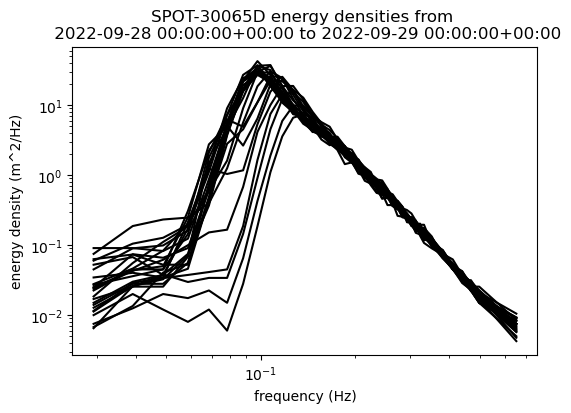

In [7]:
# example: plot energy as a function of frequency over the specified
# datetimes (a loop is the easiest way to do this)
fig, ax = plt.subplots(figsize=(6,4))
for E,f in zip(spotter[spotter_id][start_date:end_date]['energy_density'],
               spotter[spotter_id][start_date:end_date]['frequency']):
    ax.plot(f, E, color='k')

ax.set_ylabel('energy density (m^2/Hz)')
ax.set_xlabel('frequency (Hz)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'{spotter_id} energy densities from \n {start_date} to {end_date}')

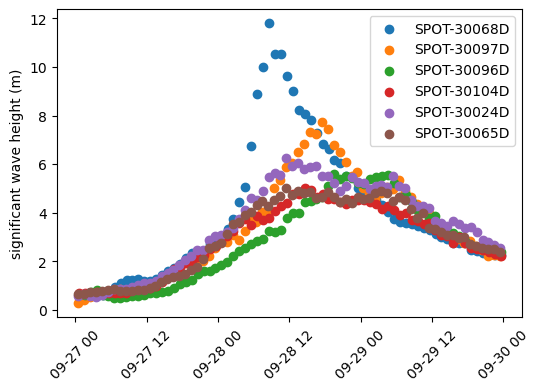

In [8]:
# Finally, the uniformity of the dataset enables multiple drifters (of
# different ID or type) to be operated on in a loop. For example, plot
# the significant wave height for every Spotter:
fig, ax = plt.subplots(figsize=(6,4))
for spotter_id in spotter.keys():
    ax.scatter(
        spotter[spotter_id].index,
        spotter[spotter_id]['significant_height'],
        label = spotter_id,
    )
ax.set_ylabel('significant wave height (m)')
ax.legend()
ax.tick_params(axis='x', rotation=45)

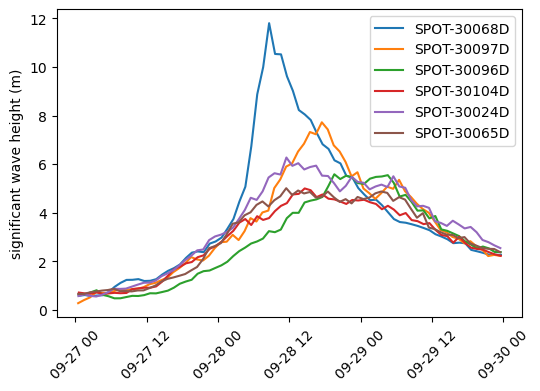

In [9]:
# Important note: some Spotter datasets contain barometer and 
# temperature measurements interspersed at a different time interval
# than the wave measurements. This means rows corresponding to times 
# where there are pressure and temperature measurements but not wave 
# measurements will contain NaNs for wave properties. This is rarely a 
# problem, except for when a lineplot or the extraction of all
# spectral data as a single matrix is desired. In these cases, the rows
# containing NaNs can be filtered out using the notnull() method (and
# the wave data can be assigned to a new variable, if neccessary).
only_waves = spotter[spotter_id]['energy_density'].notnull()
spotter[spotter_id][only_waves]

# example: plot significant wave height for every Spotter but this time
# as a lineplot (which cannot handle NaNs)
fig, ax = plt.subplots(figsize=(6,4))
for spotter_id in spotter.keys():
    only_waves = spotter[spotter_id]['energy_density'].notnull()
    ax.plot(
        spotter[spotter_id][only_waves].index,
        spotter[spotter_id][only_waves]['significant_height'],
        label = spotter_id,
    )
ax.set_ylabel('significant wave height (m)')
ax.legend()
ax.tick_params(axis='x', rotation=45)